In [1]:
import os, sys, re
from functools import partial

import scipy
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import shap

import dproc, sgml, sgutil

print(sys.version)
for i in [scipy, sklearn, mpl, sns, np, pd, pl, cb, lgb, xgb, shap]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
scipy 1.14.0
sklearn 1.5.1
matplotlib 3.9.1.post1
seaborn 0.13.2
numpy 1.26.4
pandas 2.2.2
polars 1.17.1
catboost 1.2.7
lightgbm 4.5.0
xgboost 2.1.1
shap 0.46.0


# Data acquirement

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'org.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('org_parquet', data_path, 'org.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['var_pkl'])):
    !kaggle competitions download -c playground-series-s4e12
    !mkdir data
    !unzip playground-series-s4e12.zip -d data
    !rm playground-series-s4e12.zip
    !kaggle datasets download -d schran/insurance-premium-prediction
    !unzip insurance-premium-prediction.zip
    !mv "Insurance Premium Prediction Dataset.csv" "data/org.csv"
    !rm insurance-premium-prediction.zip

In [3]:
if not os.path.exists(files['var_pkl']):
    features = """
    1. Age: Age of the insured individual (Numerical)
    2. Gender: Gender of the insured individual (Categorical: Male, Female)
    3. Annual Income: Annual income of the insured individual (Numerical, skewed)
    4. Marital Status: Marital status of the insured individual (Categorical: Single, Married, Divorced)
    5. Number of Dependents: Number of dependents (Numerical, with missing values)
    6. Education Level: Highest education level attained (Categorical: High School, Bachelor's, Master's, PhD)
    7. Occupation: Occupation of the insured individual (Categorical: Employed, Self-Employed, Unemployed)
    8. Health Score: A score representing the health status (Numerical, skewed)
    9. Location: Type of location (Categorical: Urban, Suburban, Rural)
    10. Policy Type: Type of insurance policy (Categorical: Basic, Comprehensive, Premium)
    11. Previous Claims: Number of previous claims made (Numerical, with outliers)
    12. Vehicle Age: Age of the vehicle insured (Numerical)
    13. Credit Score: Credit score of the insured individual (Numerical, with missing values)
    14. Insurance Duration: Duration of the insurance policy (Numerical, in years)
    15. Premium Amount: Target variable representing the insurance premium amount (Numerical, skewed)
    16. Policy Start Date: Start date of the insurance policy (Text, improperly formatted)
    17. Customer Feedback: Short feedback comments from customers (Text)
    18. Smoking Status: Smoking status of the insured individual (Categorical: Yes, No)
    19. Exercise Frequency: Frequency of exercise (Categorical: Daily, Weekly, Monthly, Rarely)
    20. Property Type: Type of property owned (Categorical: House, Apartment, Condo)
    """
    df_var = pd.DataFrame(
        [pd.Series(re.findall("[0-9]+. (?P<name>[^:]+): (?P<desc>.+)", i)[0], index=['name', 'Description']) for i in features.split('\n') if len(i) != 0],
    ).set_index('name')
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test', 'org']
    ])
    pl_type = dproc.get_type_pl(
        df_type, 
        {
            'Smoking Status': pl.Categorical, 'Gender': pl.Categorical, 'Marital Status': pl.Categorical, 'Education Level': pl.Categorical,
            'Occupation': pl.Categorical, 'Location': pl.Categorical, 'Policy Type': pl.Categorical, 'Smoking Status': pl.Categorical,
            'Exercise Frequency': pl.Categorical, 'Property Type': pl.Categorical
        }
    )
    df_var = pd.concat([
        df_var,
        df_type,
        pd.Series(pl_type, name = 'pl_type')
    ], axis=1)
    df_var
    pl.scan_csv('data/train.csv', schema_overrides = pl_type).sink_parquet(files['train_parquet'])
    pl.scan_csv('data/test.csv', schema_overrides = pl_type).sink_parquet(files['test_parquet'])
    pl.scan_csv('data/org.csv', schema_overrides = pl_type).sink_parquet(files['org_parquet'])
    df_var.to_pickle(files['var_pkl'])
    !rm data/train.csv
    !rm data/test.csv
    !rm data/org.csv
df_var = pd.read_pickle(files['var_pkl'])
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [4]:
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_org = pl.read_parquet(files['org_parquet'])

In [5]:
ord_list = [
    ('Education Level', {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}),
    ('Location', {"Rural": 0, "Suburban": 1, "Urban": 2}),
    ('Policy Type', {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}),
    ('Exercise Frequency', {'Daily': 0, 'Weekly': 1, 'Monthly': 2, 'Rarely': 3}),
    ('Customer Feedback', {'Poor': 0, 'Average': 1, 'Good': 2}),
]

proc_list=[
    (i, pl.col(i).cast(pl.String).replace(d).cast(pl.Int8), ['{}: {}'.format(k, v) for k, v in d.items()])
    for i, d in ord_list 
]
proc_list += [
    ('Smoking Status', (pl.col('Smoking Status') == 'Yes').cast(pl.Int8), '0: No, 1: Yes'),
    ('Gender', (pl.col('Gender') == 'Male').cast(pl.Int8), '0: Female, 1: Male')
]

In [6]:
df_train, df_var_proc = dproc.apply_with_columns(df_train, proc_list, 'org')
df_var = pd.concat([
    df_var,
    df_var_proc
], axis = 0).assign(
    src = lambda x: x['src'].fillna('org')
).groupby(level=0).last()
df_test = dproc.apply_with_columns(df_test, proc_list)
df_org = dproc.apply_with_columns(df_org, proc_list)

df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')
df_org = df_org.to_pandas()

In [7]:
pd_vars= dproc.PD_Vars.load_or_create(os.path.join('data', 'vars') , df_var)

In [8]:
X_bool = ['Gender', 'Smoking Status']
X_ord = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency', 'Customer Feedback', 'Weekday', 'Day', 'Year', 'Month']
X_nom = ['Marital Status', 'Occupation', 'Property Type']
X_cat = X_bool + X_ord + X_nom
X_num = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims', 'Vehicle Age']

In [9]:
df_train = pd_vars.put_proc('org', df_train, [(lambda x: pd.to_datetime(x['Policy Start Date']), 'Start date of the insurance policy')])

In [10]:
def date_proc(x):
    return pd.concat([
        x['Policy Start Date'].dt.year.astype('category').rename('Year'),
        x['Policy Start Date'].dt.month.astype('category').rename('Month'),
        x['Policy Start Date'].dt.day.astype('category').rename('Day'),
        x['Policy Start Date'].dt.weekday.astype('category').rename('Weekday'),
    ], axis=1)
df_train = pd_vars.put_proc('date_proc', df_train, [
    (date_proc, {'Year': 'Policy Start Date의 Year',
                'Month': 'Policy Start Date 의 Month',
                'Day': 'Policy Start Date의 Day', 
                'Weekday': 'Policy Start Date의 Weekday'})
    ])
df_test, _ = pd_vars.procs_all(df_test)
df_org , _= pd_vars.procs_all(df_org)
pd_vars.save()

In [11]:
df_train['Premium Amount_l'] = np.log(df_train['Premium Amount'])
target = 'Premium Amount_l'

# Target Distribution

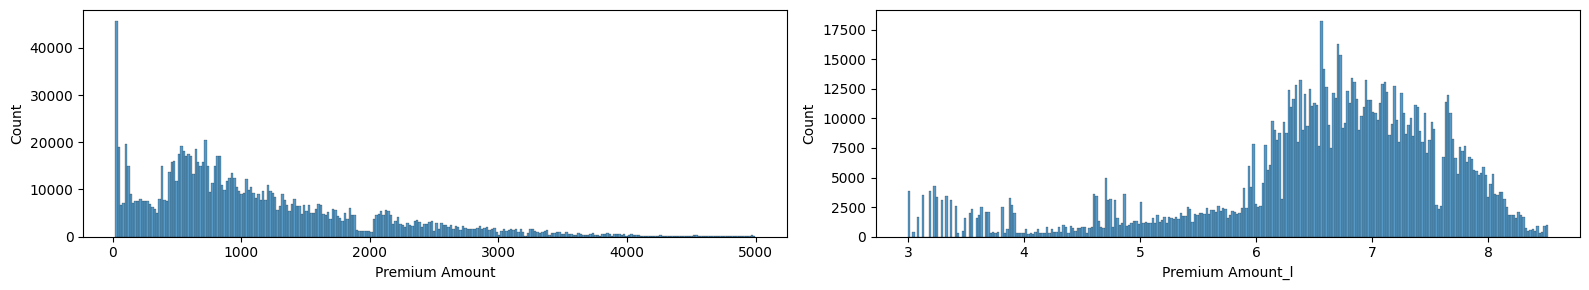

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
sns.histplot(df_train['Premium Amount'], ax=axes[0])
sns.histplot(df_train['Premium Amount_l'], ax=axes[1])
plt.tight_layout()
plt.show()

In [13]:
df_train[target].agg(['min', 'max', 'median', 'mean']), df_train[target].mode()[0]

(min       2.995732
 max       8.516994
 median    6.770790
 mean      6.590527
 Name: Premium Amount_l, dtype: float32,
 3.218876)

In [14]:
df_train[target].value_counts().iloc[:10]

Premium Amount_l
3.218876    4268
3.178054    3901
2.995732    3849
3.135494    3524
3.332205    3418
3.258096    3375
3.871201    3307
3.367296    3139
4.605170    3125
3.295837    3074
Name: count, dtype: int64

# Categorical Variables

In [15]:
from scipy.stats import kruskal, chi2_contingency
from scipy.spatial.distance import cdist, pdist, squareform

In [16]:
pd.concat([
    df_train[i].value_counts().to_frame().pipe(lambda x: x.set_index(pd.MultiIndex.from_product([[i], x.index.tolist()], names=['Var', 'Cat'])))
    for i in X_nom
], axis = 0)

count
Var            Cat                  
Marital Status Single         395391
               Married        394316
               Divorced       391764
Occupation     Employed       282750
               Self-Employed  282645
               Unemployed     276530
Property Type  House          400349
               Apartment      399978
               Condo          399673

In [17]:
df_kruskal_tgt = sc.cache_result(
    'kruskal_tgt',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index = ['stat', 'pvalue'], name = i
        )
        for i in X_bool + X_ord + X_nom
    ], axis=1), rerun = False
)
df_kruskal_tgt.sort_values('pvalue', axis=1, ascending=True)

,Year,Month,Occupation,Customer Feedback,Location,Education Level,Policy Type,Property Type,Exercise Frequency,Marital Status,Smoking Status,Weekday,Day,Gender
stat,7.440078e+02,7.051816e+01,6.276566,4.409469,3.429708,3.804265,1.907457,1.738442,2.756426,1.167640,0.169736,3.844106,22.607314,0.017928
pvalue,1.495212e-158,9.736743e-11,0.043357,0.110280,0.179990,0.283390,0.385302,0.419278,0.430723,0.557764,0.680346,0.697763,0.831053,0.893486


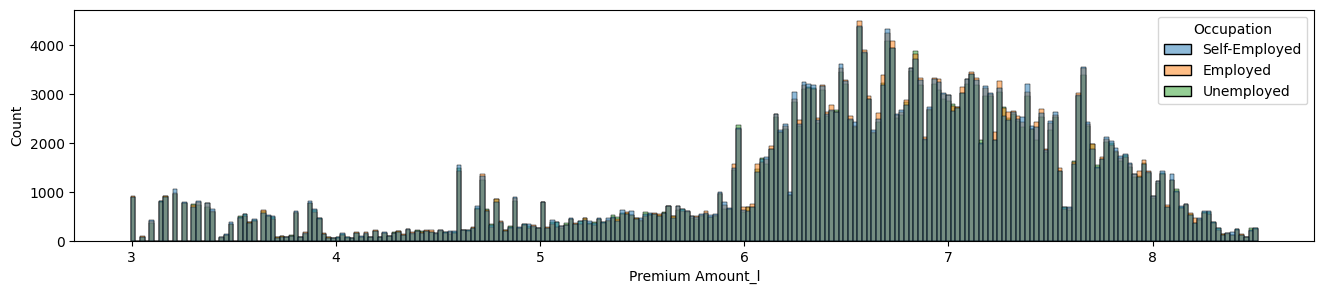

In [18]:
plt.figure(figsize=(16, 3))
sns.histplot(df_train, x=target ,hue='Occupation')
plt.show()

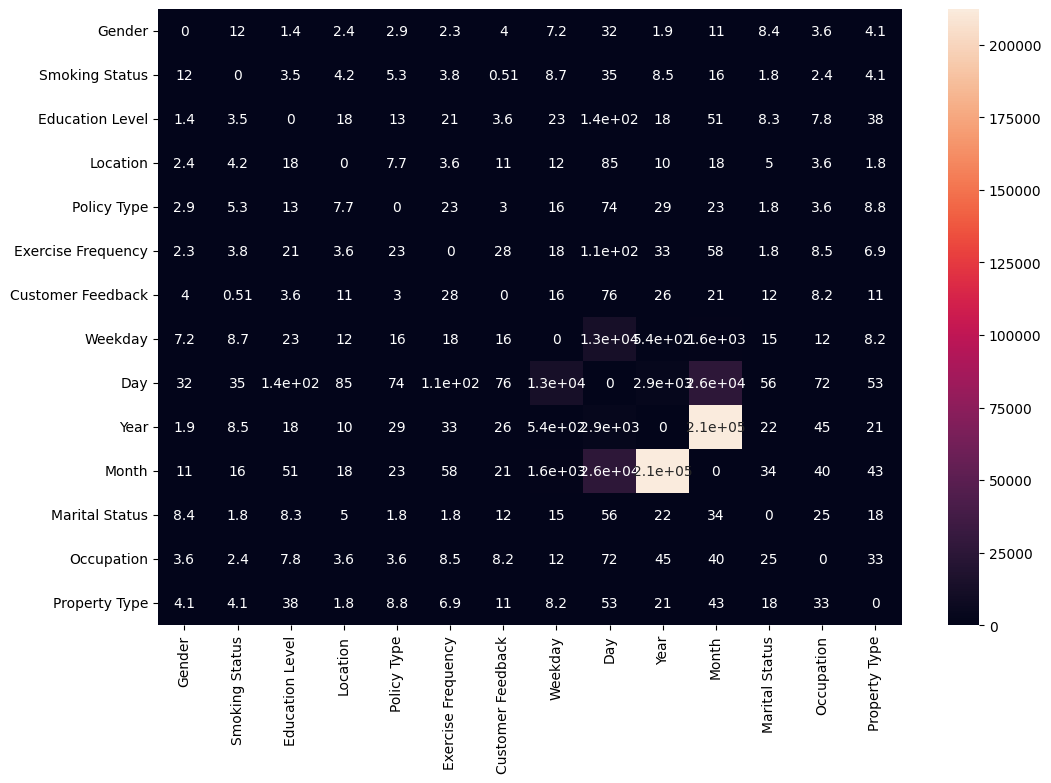

In [19]:
plt.figure(figsize=(12, 8))
df_chi2 = sc.cache_result(
    'chi2_stat',
    lambda : pd.DataFrame(
        squareform(pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns = v))[0])),
        index = X_cat, columns=X_cat
    ), rerun = False
)
sns.heatmap(df_chi2, annot=True)
plt.show()

# Numeric Variables

In [20]:
from scipy.stats import kruskal, spearmanr

# Policy Start Date에서 Policy가 적용된 기간을 Policy의 최대값에서 도출합니다.
if 'Policy Days' not in df_train.columns:
    df_train['Policy Days'] = (df_train['Policy Start Date'].max() - df_train['Policy Start Date']).dt.days
    df_test['Policy Days'] = (df_train['Policy Start Date'].max() - df_test['Policy Start Date']).dt.days
    df_org['Policy Days'] = (df_train['Policy Start Date'].max() - df_org['Policy Start Date']).dt.days
    X_num.append('Policy Days') 

## Spearman with target

In [21]:
df_spearman_target = sc.cache_result('spearman_target',
    lambda : pd.concat([
        pd.Series(
            df_train[[i, target]].dropna().pipe(lambda x: spearmanr(x[i], x[target])),
            index = ['stat', 'pvalue'], name = i
        )
        for i in X_num
    ], axis=1)
).sort_values('pvalue', ascending=True, axis=1)
df_spearman_target

,Annual Income,Credit Score,Previous Claims,Health Score,Policy Days,Age,Number of Dependents,Vehicle Age,Insurance Duration
stat,-0.061437,-0.043928,0.044549,1.601483e-02,1.018274e-02,-0.002329,-0.001610,0.000870,-0.000071
pvalue,0.000000,0.000000,0.000000,9.044248e-65,6.775903e-29,0.011369,0.092669,0.340707,0.937799


## Spearman between variables

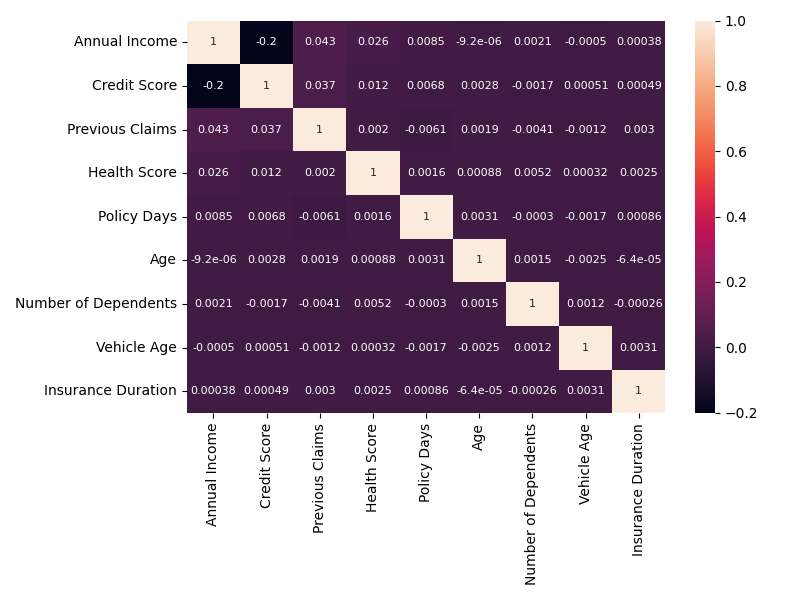

In [22]:
sc.cache_fig('spearman_between variables',
    lambda x: sns.heatmap(
        df_train[
            df_spearman_target.T['pvalue'].sort_values(ascending=True).index
        ].corr(), annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (8, 6)
)

## Kruskal with Categorical Variables

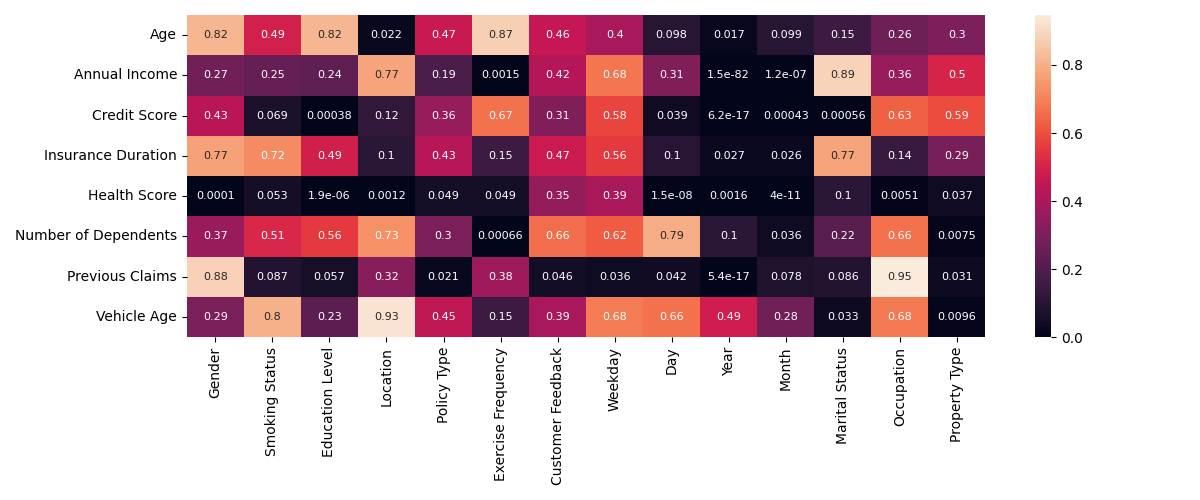

In [23]:
df_kruskal_cat = sc.cache_result('kruskal_cat', 
    lambda : pd.concat([
        df_train.groupby(df_train[i], observed=True)[X_num].agg(lambda x: x.dropna().tolist()).apply(
            lambda x: kruskal(*x).pvalue, axis=0
        ).rename(i)
        for i in X_cat
    ], axis = 1), rerun = False
)

sc.cache_fig('kruskal_cat',
    lambda x: sns.heatmap(
        df_kruskal_cat, annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (12, 5), redraw = False
)

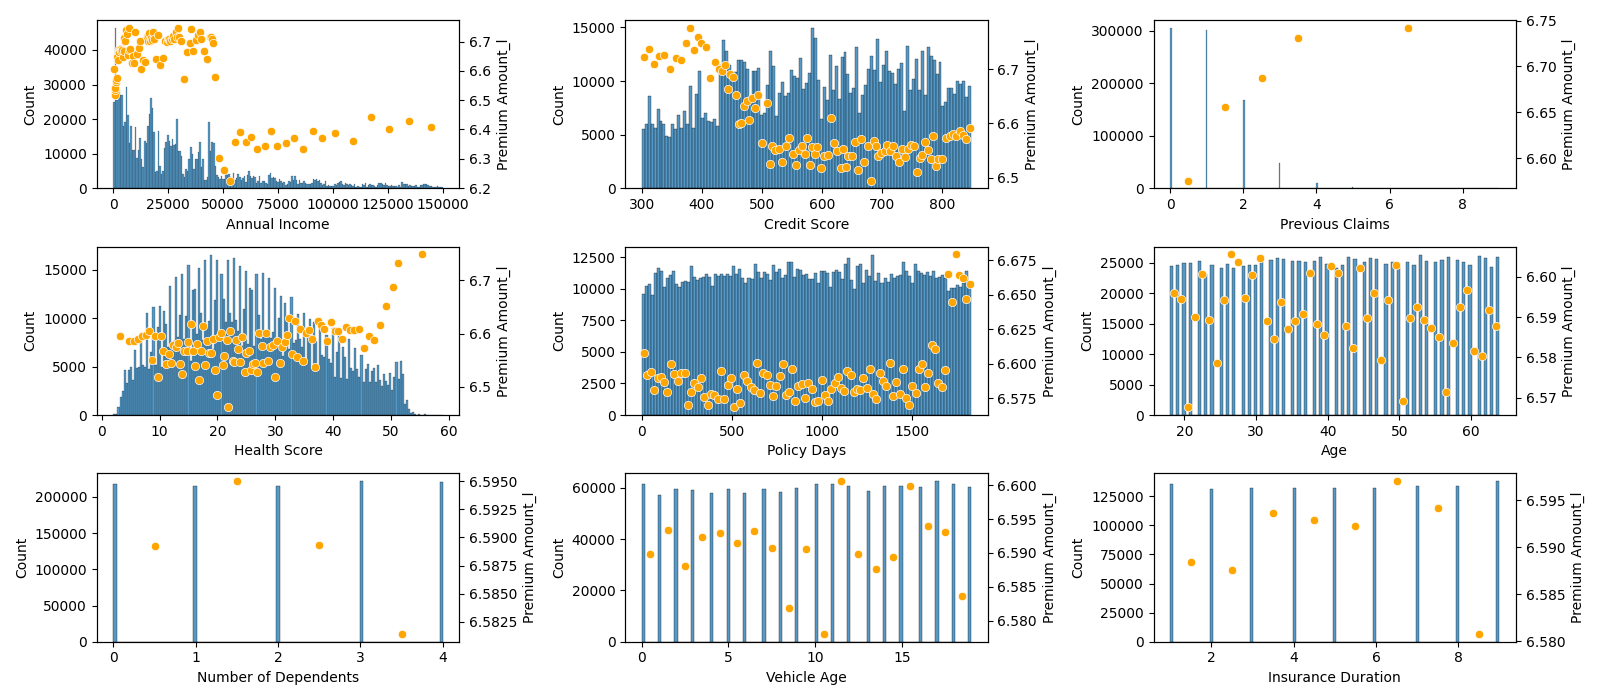

In [24]:
def hist_and_scatter(df, col, ax):
    sns.histplot(df[col], ax=ax)
    df_train.groupby(pd.qcut(df[col], q=100, duplicates='drop'), observed=True)[[target]].mean().assign(
        x = lambda x: x.index.map(lambda x: (x.left + x.right) / 2)
    ).rename(columns = {'x': col}).pipe(
        lambda x: sns.scatterplot(x, x = col, y = target, ax=ax.twinx(), color='orange')
    )
X = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter',
    lambda axes: [hist_and_scatter(df_train, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7)
)

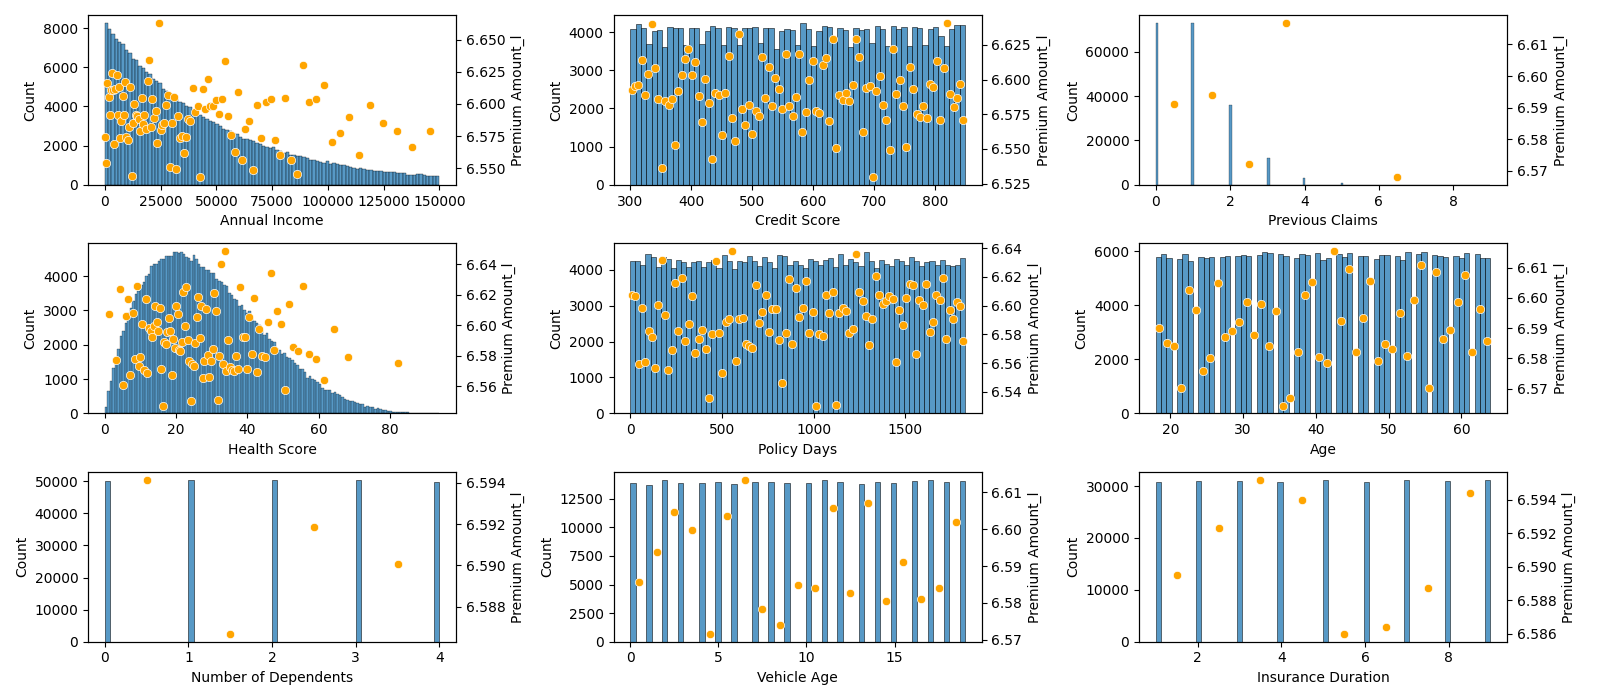

In [25]:
def hist_and_scatter(df, col, ax):
    sns.histplot(df[col], ax=ax)
    df_train.groupby(pd.qcut(df[col], q=100, duplicates='drop'), observed=True)[[target]].mean().assign(
        x = lambda x: x.index.map(lambda x: (x.left + x.right) / 2)
    ).rename(columns = {'x': col}).pipe(
        lambda x: sns.scatterplot(x, x = col, y = target, ax=ax.twinx(), color='orange')
    )
X = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter_org',
    lambda axes: [hist_and_scatter(df_org, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw=0
)

# Missing Variables

In [26]:
pd.concat([
    df_train[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(train)').sort_values(ascending=False).to_frame().T,
    df_test[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(test)').sort_values(ascending=False).to_frame().T,
    df_org[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(org)').sort_values(ascending=False).to_frame().T
], axis=0).fillna(0)

,Previous Claims,Occupation,Credit Score,Number of Dependents,Customer Feedback,Health Score,Annual Income,Age,Marital Status,Vehicle Age,Insurance Duration
na_rate(train),0.303358,0.298396,0.114902,0.091393,0.064853,0.061730,0.037457,0.015588,0.015441,0.000005,8.333333e-07
na_rate(test),0.303503,0.298906,0.114314,0.091412,0.065345,0.061811,0.037325,0.015611,0.015420,0.000004,2.500000e-06
na_rate(org),0.291501,0.291501,0.100000,0.100000,0.065800,0.038001,0.050043,0.016801,0.017998,0.000000,0.000000e+00


In [27]:
if 'Previous Claims_isna' not in df_train.columns:
    X_isna = ['Previous Claims', 'Occupation', 'Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age', 'Marital Status']
    df_train = df_train.join(df_train[X_isna].rename(columns = lambda x: x + '_isna'))
    df_org = df_org.join(df_org[X_isna].rename(columns = lambda x: x + '_isna'))
    X_isna = [i + '_isna' for i in X_isna]

## Missing Value Processing

In [28]:
# 수치형 변수의 결측치를 0으로 채웁니다.
if 'Previous Claims_fz' not in df_train.columns:
    X_fn = ['Previous Claims', 'Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age']
    df_fz = df_train[X_fn].fillna(0).rename(columns = lambda x: x + '_fz')
    X_fz = df_fz.columns.tolist()
    df_train = df_train.join(df_fz)

In [29]:
# 명목형 변수의 결측치를 Unknown으로 채웁니다.
if 'Occupation_funk' not in df_train.columns:
    df_train['Occupation_funk'] = df_train['Occupation'].cat.add_categories('Unknown').fillna('Unknown')
    df_train['Marital Status_funk'] = df_train['Marital Status'].cat.add_categories('Unknown').fillna('Unknown')
    df_train['Customer Feedback_fm1'] = df_train['Customer Feedback'].fillna(-1).astype('int8')

# Train/Test/Org Difference

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_roc_auc_diff(df_0, df_1, X_input):
    df_diff = pd.concat([
        df_0[X_input].assign(is_1 = False),
        df_1[X_input].assign(is_1 = True)
    ], axis = 0)
    df_train_diff, df_test_diff = train_test_split(df_diff, train_size = 0.8, stratify = df_diff['is_1'])
    clf_diff = lgb.LGBMClassifier(random_state=123, verbose = 0)
    clf_diff.fit(df_diff[X_input], df_diff['is_1'], categorical_feature = X_cat)
    return (
        roc_auc_score(df_test_diff['is_1'], clf_diff.predict_proba(df_test_diff[X_input])[:, 1]),
        pd.Series(clf_diff.feature_importances_, index=X_input)
    )
(roc1, s_imp1), (roc2, s_imp2) = sc.cache_result('diff_result',
    lambda : (
        get_roc_auc_diff(df_train, df_test, X_cat + X_num),
        get_roc_auc_diff(df_train, df_org, X_cat + X_num + ['Premium Amount'] + X_isna)
    ), rerun=0
)
roc1, roc2

(0.5357095850911459, 0.8108993313550408)

In [31]:
s_imp2.sort_values(ascending=False).iloc[:15].to_frame().T

,Annual Income,Health Score,Premium Amount,Credit Score,Previous Claims,Marital Status_isna,Policy Days,Number of Dependents,Education Level,Age,Occupation_isna,Exercise Frequency,Vehicle Age,Age_isna,Annual Income_isna
0,883,757,650,399,150,72,67,11,4,3,2,1,1,0,0


Train은 Test와 구분이 어려운 것으로 보아 차이가 크지 않음을 알 수 있고,

Org와는 차이가 보입니다. Org 데이터를 포함하여 학습시키는 것은 성능의 개선을 주지 않을 가능성이 큽니다. 

In [32]:
from sklearn.metrics import mean_squared_error
def check_improve():
    df_org[target] = np.log(df_org['Premium Amount'] + 1e-7)
    df_train_2, df_valid = train_test_split(df_train, train_size = 0.8)
    return (
        mean_squared_error(
            df_valid[target],
            lgb.LGBMRegressor(random_state = 123, verbose=0).fit(df_train_2[X_cat + X_num], df_train_2[target]).predict(df_valid[X_cat + X_num])
        ),
        mean_squared_error(
            df_valid[target],
            pd.concat([df_train_2[X_cat + X_num + [target]], df_org[X_cat + X_num + [target]]])\
            .pipe(lambda x: lgb.LGBMRegressor(random_state = 123, verbose=0).fit(x[X_cat + X_num], x[target]).predict(df_valid[X_cat + X_num]))
        )
    )
sc.cache_result('check_improve', check_improve)

(1.1154423300794376, 1.1327478698101194)

# Analyze with ML

In [33]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import mean_squared_error
kf = KFold(5, random_state=123, shuffle=True)
ss = ShuffleSplit(1, random_state=123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index=df.index),
    'score_func': lambda df, prds: mean_squared_error(df[target].sort_index(), prds.sort_index()) ** 0.5,
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': target,
}

cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)

In [34]:
def gb_shap_learning_result(train_result, df, interaction = True):
    explainer = shap.TreeExplainer(train_result['model'])
    processor = train_result['preprocessor']
    result = {
        'X': pd.DataFrame(processor.transform(df), index=df.index, columns=train_result['variables'])
    }
    result['shap_values'] = explainer.shap_values(result['X'])
    if interaction:
        result['shap_interaction_values'] = explainer.shap_interaction_values(result['X'])
    return result

def cb_interaction_importance(train_result):
    s_name = pd.Series(train_result['variables'])
    return pd.DataFrame(
        train_result['model'].get_feature_importance(type = 'Interaction'),
        columns = ['Var1', 'Var2', 'Importance']
    ).assign(
        Var1 = lambda x: x['Var1'].map(s_name),
        Var2 = lambda x: x['Var2'].map(s_name),
    )

In [35]:
X_ord2 = [i for i in X_ord if i != 'Customer Feedback']
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num, 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, partial(gb_shap_learning_result, df=df_train.sample(frac=0.1)), cb_interaction_importance]
    ), rerun=True
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.0539883610231557], [1.0521880010487359])

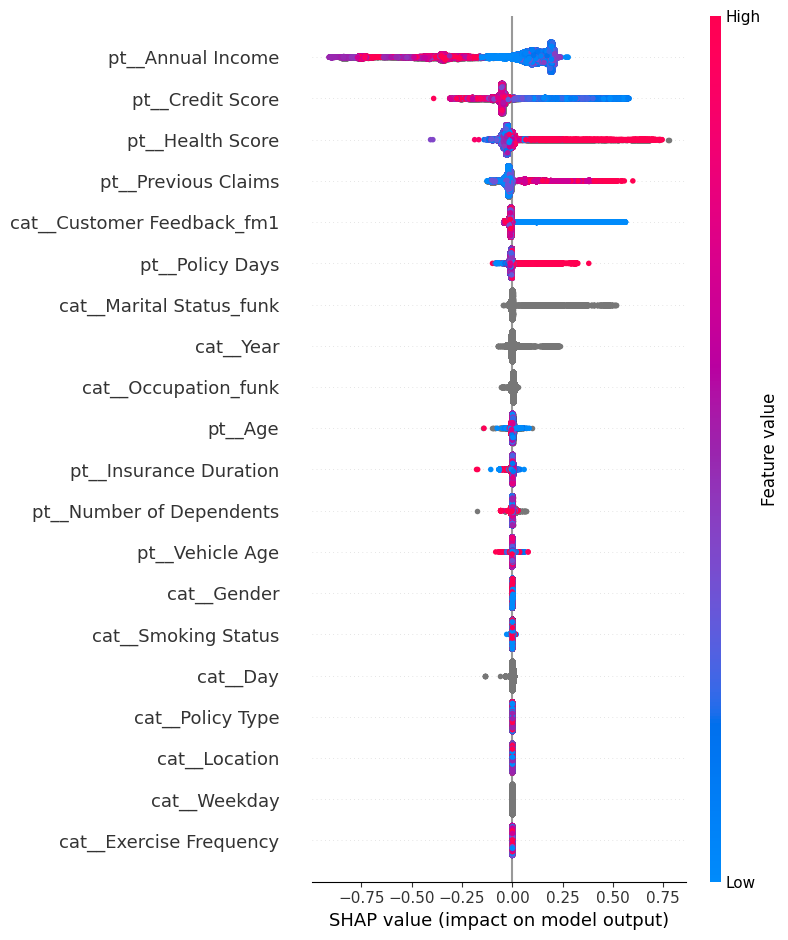

In [36]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

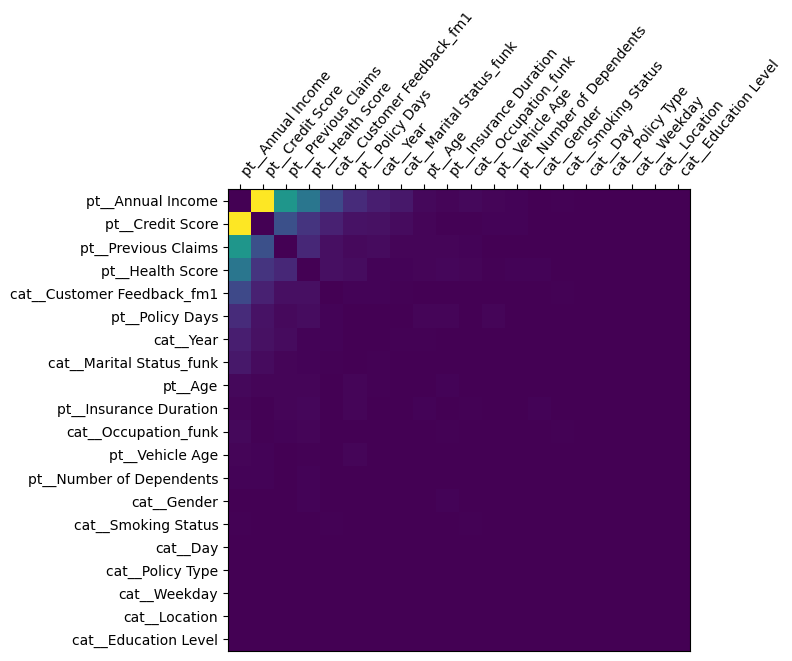

In [37]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

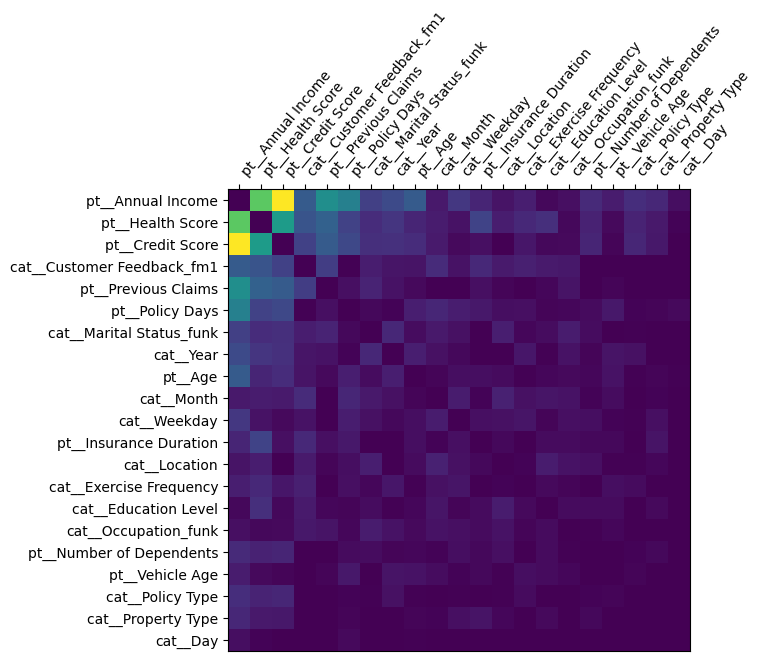

In [38]:
df_cb_inter = pd.concat([
    result['model_result'][2],
    result['model_result'][2].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

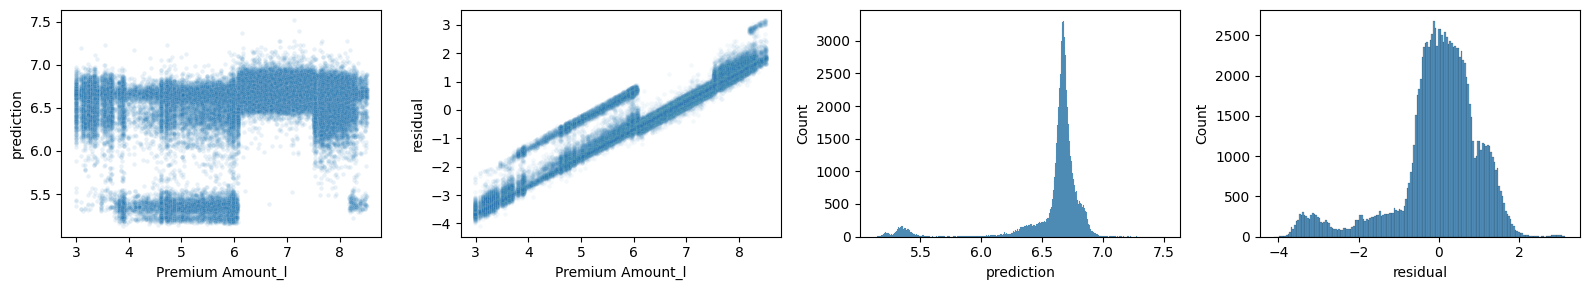

In [39]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')
sns.scatterplot(
    x = y_true, y = y_prd, alpha = 0.1, s = 10, ax=axes[0]
)
sns.scatterplot(
    x = y_true, y = residual, alpha = 0.05, s = 10, ax=axes[1]
)
sns.histplot(
    y_prd, ax = axes[2]
)
sns.histplot(
    residual, ax = axes[3]
)
plt.tight_layout()
plt.show()

target이 4와 6 사이 그리고 8 이상인 구간에서ㅓ 예측값의 분포는 6.5 와 5.4 중심으로 나뉜다는 것을 알 수 있습니다. 이 현상을 살펴 봅니다.

In [40]:
df_valid[X_ord + ['Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns =y_prd < 6.0))
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

,Year,Marital Status_funk,Month,Location,Education Level,Weekday,Gender,Smoking Status,Day,Property Type,Exercise Frequency,Occupation_funk,Policy Type,Customer Feedback
stat,2.364787e+02,6.503205e+01,33.040586,3.767016,4.906023,7.644077,0.793756,0.166094,25.53296,0.430001,0.766566,0.476485,0.099344,0.029353
pvalue,4.368169e-49,4.937458e-14,0.000518,0.152056,0.178809,0.265356,0.372967,0.683607,0.69874,0.806541,0.857446,0.924026,0.951541,0.985431


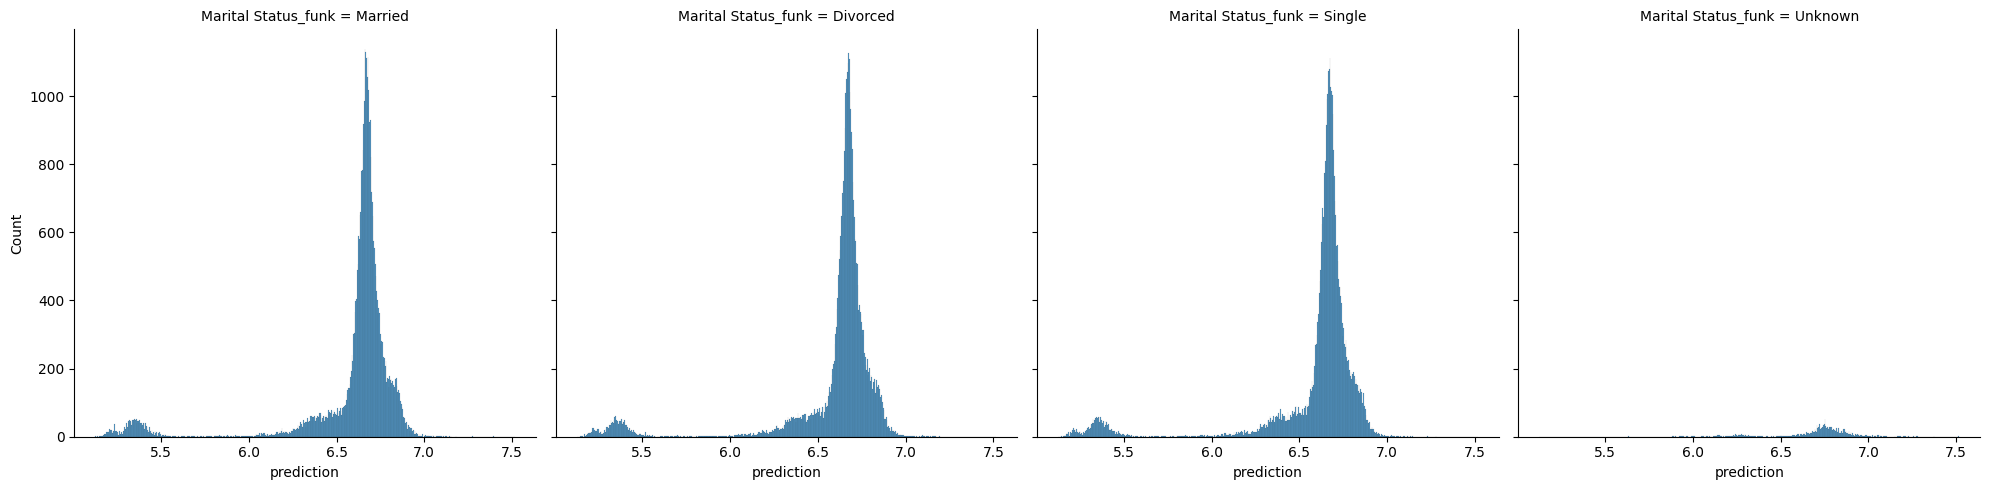

In [41]:
sns.displot(
    x=y_prd.rename('prediction'), col = df_valid['Marital Status_funk']
)

In [42]:
df_valid[X_num].isna().apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns =y_prd < 6.0))
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

,Annual Income,Health Score,Previous Claims,Credit Score,Age,Number of Dependents,Insurance Duration,Vehicle Age,Policy Days
stat,6257.15151,3.086195e+02,1.636195e+02,9.680562e+01,0.796043,0.058235,0.0,0.0,0.0
pvalue,0.00000,4.364683e-69,1.831818e-37,7.647868e-23,0.372279,0.809307,1.0,1.0,1.0


In [43]:
from scipy.stats import mannwhitneyu
df_valid[X_num].apply(
    lambda x: mannwhitneyu(x.loc[y_prd < 6.0].dropna(), x.loc[y_prd >= 6.0].dropna())
).apply(
    lambda x: pd.Series(list(x)[:2], index = ['stat', 'pvalue'])
).sort_values('pvalue', ascending=True, axis=1)

,Annual Income,Credit Score,Previous Claims,Policy Days,Health Score,Vehicle Age,Number of Dependents,Age,Insurance Duration
stat,497176192.5,3.530481e+08,1.144777e+08,3.435589e+08,3.288954e+08,3.568682e+08,3.027872e+08,3.551334e+08,3.643577e+08
pvalue,0.0,4.332639e-299,4.568431e-214,1.138916e-12,5.855080e-03,2.997973e-02,1.278878e-01,2.377475e-01,5.396336e-01


In [44]:
pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Health Score            0.000013
Annual Income           0.000864
Previous Claims         0.004043
Age                     0.126025
Number of Dependents    0.586047
Marital Status          0.883825
Customer Feedback       0.921517
Credit Score            0.980252
Occupation              0.990430
dtype: float64

Health Score의 결측 여부와 Annual Income의 결측 여부는 잔차와 관련성이 높고 또한 위에서 제시한 예측 결과가 6.5와 5.4 주변으로 분리된 현상과 관련이 있음을 알 수 있습니다.

## Missing Variable Imputation with ML

### Health Score

In [45]:
df_kruskal_cat.loc['Health Score'].sort_values().to_frame().T

,Month,Day,Education Level,Gender,Location,Year,Occupation,Property Type,Policy Type,Exercise Frequency,Smoking Status,Marital Status,Customer Feedback,Weekday
Health Score,3.984273e-11,1.474154e-08,0.000002,0.000102,0.001243,0.001639,0.005065,0.037185,0.048545,0.04929,0.053193,0.104752,0.353783,0.393192


In [47]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Health Score'].sort_values(ascending = False).iloc[1:].to_frame().T

,Annual Income,Credit Score,Number of Dependents,Insurance Duration,Previous Claims,Policy Days,Age,Vehicle Age
Health Score,0.02553,0.012016,0.005152,0.002487,0.001989,0.00157,0.000881,0.000316


In [48]:
from sklearn.model_selection import cross_validate

X_H_cat = ['Year', 'Month', 'Education Level', 'Gender', 'Location', 'Occupation']
clf_lgb = lgb.LGBMClassifier(
    n_estimators = 300, learning_rate = 0.03,
    verbose = 0
)
sc.cache_result(
    'lgb_health_score',
    lambda :
        df_train.loc[df_train['Health Score'].notna()].pipe(
            lambda x: cross_validate(
                clf_lgb, x[X_H_cat + ['Annual Income', 'Credit Score']], x['Health Score'] > 50, scoring = 'roc_auc', cv = 5, 
                params = {'categorical_feature': X_H_cat}, return_train_score = True
            )
        )
    ,rerun = False
)

{'fit_time': array([3.94849443, 3.99214005, 3.85859942, 4.10651398, 3.98510504]),
 'score_time': array([0.57600141, 0.5320003 , 0.5540781 , 0.58299947, 0.60299897]),
 'test_score': array([0.68102156, 0.6797946 , 0.68462842, 0.68380156, 0.68300535]),
 'train_score': array([0.7373893 , 0.73636351, 0.72863371, 0.73260448, 0.73749458])}

In [49]:
clf_lgb = sc.cache_result(
    'lgb_health', 
    lambda :df_train.loc[df_train['Health Score'].notna()].pipe(
        lambda x: clf_lgb.fit(x[X_H_cat + ['Annual Income', 'Credit Score']], x['Health Score'] >= 50)
    ), rerun = True
)
df_train['Health Score_50'] = np.where(df_train['Health Score'] >= 50, 1.0, 0.0)
df_train.loc[df_train['Health Score'].isna(), 'Health Score_50'] = clf_lgb.predict_proba(
    df_train.loc[df_train['Health Score'].isna(), X_H_cat + ['Annual Income', 'Credit Score']]
)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [50]:
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num + ['Health Score_50'], 'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb2', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result]
    ), rerun=True
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.0540165705058822], [1.0519561077001074])

In [51]:
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')

pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Health Score            0.000387
Annual Income           0.000993
Previous Claims         0.010588
Age                     0.135846
Number of Dependents    0.409618
Marital Status          0.728017
Credit Score            0.800287
Customer Feedback       0.805861
Occupation              0.880294
dtype: float64

Regression 모델로 Health Score의 예측 정확도는 기대할 수 없지만, 시각화 그래프상에서 50 이상은 뚜렷하게 분포가 차이가 남을 알 수 있고, 

이를 바탕으로 50 이상 여부를 맞추는 모델은 어느 정도 성능을 기대할 수 있어 예측 결과를 사용한 결과 성능 효과를 볼 수 있었습니다.

### Annual Income

In [52]:
df_kruskal_cat.loc['Annual Income'].sort_values().to_frame().T

,Year,Month,Exercise Frequency,Policy Type,Education Level,Smoking Status,Gender,Day,Occupation,Customer Feedback,Property Type,Weekday,Location,Marital Status
Annual Income,1.499166e-82,1.203363e-07,0.001482,0.187004,0.235417,0.250826,0.271901,0.308204,0.362187,0.419487,0.504295,0.675542,0.773174,0.885622


In [53]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Annual Income'].sort_values(ascending = False).iloc[1:].to_frame().T

,Previous Claims,Health Score,Policy Days,Number of Dependents,Insurance Duration,Age,Vehicle Age,Credit Score
Annual Income,0.043065,0.02553,0.008472,0.002135,0.000379,-0.000009,-0.0005,-0.201423


In [54]:
from sklearn.model_selection import cross_validate

X_A_cat = ['Exercise Frequency', 'Year', 'Month']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, learning_rate = 0.05,
    verbose = 0
)
sc.cache_result(
    'lgb_annual_income',
    lambda :
        df_train.loc[df_train['Annual Income'].notna()].pipe(
            lambda x: cross_validate(
                reg_lgb, x[X_A_cat + ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50']], x['Annual Income'], 
                scoring = 'r2', cv = 5, 
                params = {'categorical_feature': X_A_cat}, return_train_score = True
            )
        )
    , rerun = False
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([4.8727839 , 4.91026139, 4.81877828, 4.7792778 , 4.8374598 ]),
 'score_time': array([0.87381911, 0.83150148, 0.861099  , 0.83964682, 0.91717052]),
 'test_score': array([0.1257304 , 0.12203115, 0.12454975, 0.12369047, 0.12404474]),
 'train_score': array([0.13318864, 0.13394341, 0.13338625, 0.13346617, 0.13372005])}

In [55]:
reg_lgb = sc.cache_result(
    'lgb_annual_model', 
    lambda :df_train.loc[df_train['Annual Income'].notna()].pipe(
        lambda x: reg_lgb.fit(x[X_A_cat + ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50']], x['Annual Income'])
    ), rerun = False
)
df_train['Annual Income_f'] = df_train['Annual Income']
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income_f'] = reg_lgb.predict(
    df_train.loc[df_train['Annual Income'].isna(), X_A_cat +  ['Previous Claims', 'Health Score', 'Credit Score', 'Health Score_50']]
).astype('int')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [59]:
X_num2 = ['Age', 'Annual Income_isna', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num2 + ['Health Score_50', 'Annual Income_f'],
    'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb3', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result]
    ), rerun=True
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.0535091062091841], [1.0516252238501083])

Annual Income은 결측여부와 함께 보간한 Annual Income을 같이 쓰면 효과가 있습니다.

In [60]:
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')

pd.Series([
    mannwhitneyu(residual.loc[df_valid[i].isna()], residual.loc[df_valid[i].notna()]).pvalue
    for i in pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index
], index = pd_vars.df_var.loc[pd_vars.df_var['na'] > 2000].index).sort_values(ascending=True)

Health Score            0.001202
Annual Income           0.004655
Previous Claims         0.005849
Age                     0.168273
Number of Dependents    0.420792
Occupation              0.915105
Customer Feedback       0.925928
Credit Score            0.984000
Marital Status          0.994593
dtype: float64

### Previous Claims

In [61]:
df_kruskal_cat.loc['Previous Claims'].sort_values().to_frame().T

,Year,Policy Type,Property Type,Weekday,Day,Customer Feedback,Education Level,Month,Marital Status,Smoking Status,Location,Exercise Frequency,Gender,Occupation
Previous Claims,5.431242e-17,0.020671,0.03072,0.035647,0.041818,0.046106,0.056846,0.077654,0.086356,0.086622,0.321809,0.375611,0.882875,0.946917


In [62]:
df_train[
    df_spearman_target.T['pvalue'].sort_values(ascending=True).index
].corr().loc['Previous Claims'].sort_values(ascending = False).iloc[1:].to_frame().T

,Annual Income,Credit Score,Insurance Duration,Health Score,Age,Vehicle Age,Number of Dependents,Policy Days
Previous Claims,0.043065,0.036816,0.003001,0.001989,0.001869,-0.001172,-0.004123,-0.006132


In [63]:
from sklearn.model_selection import cross_validate

X_PC_cat = ['Year', 'Policy Type', 'Property Type']
reg_lgb = lgb.LGBMRegressor(
    n_estimators = 500, learning_rate = 0.05,
    verbose = 0
)
sc.cache_result(
    'lgb_previous_claims',
    lambda :
        df_train.loc[df_train['Previous Claims'].notna()].pipe(
            lambda x: cross_validate(
                reg_lgb, x[X_PC_cat + ['Credit Score', 'Annual Income_isna', 'Annual Income_f']], x['Previous Claims'].clip(0, 4), 
                scoring = 'r2', cv = 5, 
                params = {'categorical_feature': X_PC_cat}, return_train_score = True
            )
        )
    , rerun = False
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


{'fit_time': array([3.13306379, 3.17774606, 3.41732097, 3.41260624, 3.24597597]),
 'score_time': array([0.63400078, 0.69635892, 0.62565994, 0.70599985, 0.63503313]),
 'test_score': array([0.05132809, 0.05279579, 0.05304435, 0.05236482, 0.05166897]),
 'train_score': array([0.06182408, 0.0616415 , 0.06176311, 0.06157567, 0.06192503])}

In [64]:
reg_lgb = sc.cache_result(
    'lgb_previous_claims_model', 
    lambda :df_train.loc[df_train['Previous Claims'].notna()].pipe(
        lambda x: reg_lgb.fit(x[X_PC_cat + ['Credit Score', 'Annual Income_isna', 'Annual Income_f']], x['Previous Claims'])
    ), rerun = False
)
df_train['Previous Claims_f'] = df_train['Previous Claims']
df_train.loc[df_train['Previous Claims'].isna(), 'Previous Claims_f'] = reg_lgb.predict(
    df_train.loc[df_train['Previous Claims'].isna(), X_PC_cat +  ['Credit Score', 'Annual Income_isna', 'Annual Income_f']]
).astype('float32')
df_train['Previous Claims_f'] = df_train['Previous Claims_f'].round().astype('int')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [66]:
X_num2 = ['Age', 'Annual Income_isna', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims_isna', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num2 + ['Health Score_50', 'Annual Income_f', 'Previous Claims_f'],
    'X_cat': X_ord2 + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb4', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=False
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([1.0536623822487854], [1.0512220411236568])

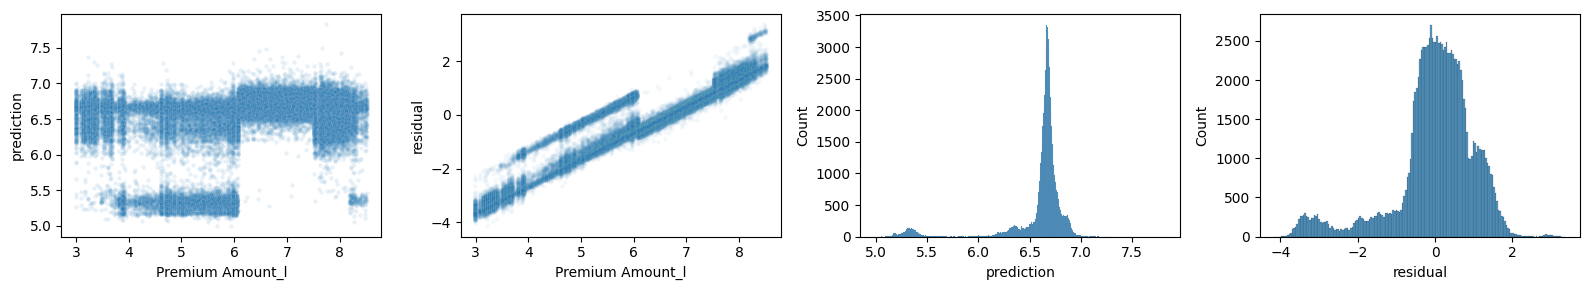

In [67]:
fig, axes = plt.subplots(1, 4, figsize = (16, 3))
y_true = df_train.loc[result['valid_prd'].index, target]
y_prd = result['valid_prd'].rename('prediction')
df_valid = df_train.loc[y_prd.index]
residual = (y_true - y_prd).rename('residual')
sns.scatterplot(
    x = y_true, y = y_prd, alpha = 0.1, s = 10, ax=axes[0]
)
sns.scatterplot(
    x = y_true, y = residual, alpha = 0.05, s = 10, ax=axes[1]
)
sns.histplot(
    y_prd, ax = axes[2]
)
sns.histplot(
    residual, ax = axes[3]
)
plt.tight_layout()
plt.show()

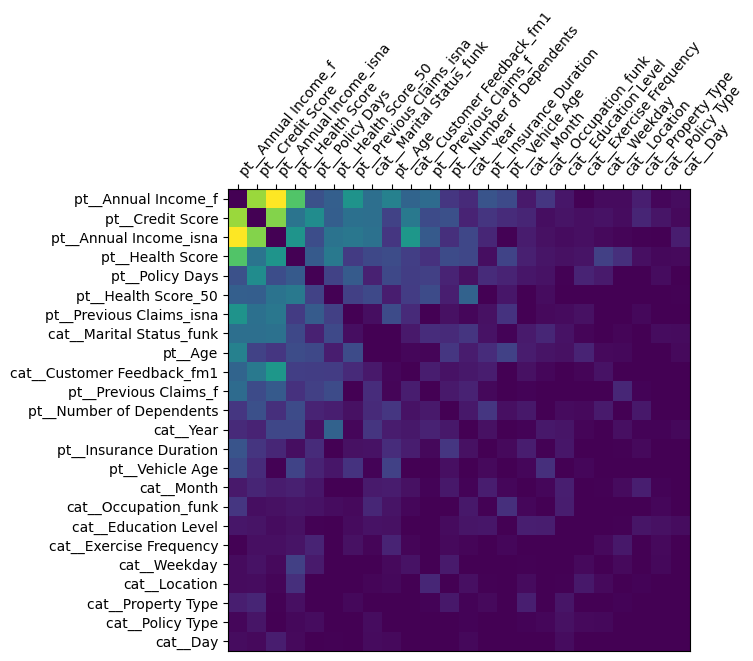

In [68]:
df_cb_inter = pd.concat([
    result['model_result'][1],
    result['model_result'][1].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_cb_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

------------------------------------

## Frequency Encoding

In [218]:
from scipy.stats import spearmanr

sc.cache_result(
    'cat_freq_corr',
    lambda : pd.concat([
        pd.Series(
        spearmanr(
            df_train[target],
            df_train[i].map(df_train[i].value_counts())
        ), index = ['r', 'pvalue'], name = i) 
        for i in X_ord[:-1] + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type', 'year', 'month', 'day', 'weekday'] + X_bool
    ], axis = 1), rerun = 1
).sort_values('pvalue', axis = 1)

,Customer Feedback_fm1,year,Occupation_funk,Marital Status_funk,month,Education Level,Exercise Frequency,Policy Type,Location,Property Type,day,Smoking Status,Gender,weekday
r,-1.373052e-02,-1.310951e-02,-0.004202,-0.003042,-0.002353,-0.001652,-0.001442,-0.001252,-0.001154,0.000954,0.000619,0.000376,0.000122,-0.000074
pvalue,3.912378e-51,9.044808e-47,0.000004,0.000861,0.009957,0.070374,0.114216,0.170116,0.206050,0.296095,0.497834,0.680346,0.893486,0.935786


In [173]:
sc.cache_result(
    'num_freq_corr',
    lambda : pd.concat([
        pd.Series(
        spearmanr(
            df_train[target],
            df_train[i].fillna(-1).pipe(lambda x: x.map(x.value_counts()))
        ), index = ['r', 'pvalue'], name = i) 
        for i in X_num
    ], axis = 1)
).sort_values('pvalue', axis = 1)

,Annual Income,Health Score,Previous Claims,Policy Days,Credit Score,Number of Dependents,Insurance Duration,Age,Vehicle Age
r,0.047605,-0.080246,-0.037168,-9.678094e-03,-7.417727e-03,-5.589687e-03,-0.003669,-0.003389,-0.000964
pvalue,0.000000,0.000000,0.000000,2.914951e-26,4.443609e-16,9.169323e-10,0.000058,0.000205,0.290855


In [187]:
freq_cols_cat = ['Customer Feedback_fm1', 'Occupation_funk', 'Marital Status_funk']
freq_cols_num = ['Annual Income', 'Health Score',  'Previous Claims', 'Policy Days', 'Credit Score', 'Number of Dependents', 'Insurance Duration', 'Age']

In [189]:
from sklearn.model_selection import KFold

df_sets = list()
for train_idx, valid_idx in KFold(5, random_state=123, shuffle=True).split(df_train, df_train[target]):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    cat_enc = [df_valid[i].map(df_cv_train[i].value_counts()).astype(int).fillna(0) for i in freq_cols_cat]
    num_enc = [df_valid[i].fillna(-1).map(df_cv_train[i].fillna(-1).value_counts()).fillna(0) for i in freq_cols_num]
    df_sets.append(pd.concat(cat_enc + num_enc, axis=1))
df_train = df_train.join(
    pd.concat(df_sets, axis = 0).rename(columns = lambda x: x + '_freq')
)

In [197]:
X_freq = [i + '_freq' for i in freq_cols_cat + freq_cols_num]
cat_enc = [df_train[i].map(df_train[i].value_counts()).astype(int).fillna(0) for i in freq_cols_cat]
num_enc = [df_train[i].fillna(-1).map(df_train[i].fillna(-1).value_counts()).fillna(0) for i in freq_cols_num]
df_train[X_freq] = pd.concat(cat_enc + num_enc, axis=1)

In [215]:
X_num2 = ['Age', 'Annual Income_isna', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims_isna', 'Vehicle Age', 'Policy Days']
hparams = {
    'model_params': {'n_estimators': 300},
    'X_num': X_num2 + ['Health Score_50', 'Annual Income_f', 'Previous Claims_f'] + X_freq,
    'X_cat': X_ord[:-1] + ['Customer Feedback_fm1', 'Marital Status_funk', 'Occupation_funk', 'Property Type', 'year', 'month', 'day', 'weekday'] + X_bool,
    'tgt': ['Annual Income'],
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb5', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, cb_interaction_importance]
    ), rerun=True
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [220]:
df_train['hour'].value_counts()

hour
15    1200000
Name: count, dtype: int64